# This notebook check available phenotypes from AWIGEN

## 1. Load all phenotypes and find samples also have genotypes
## 2. Visulize PCs
## 3. Prepar covariate files and phenotype files

Use LDL as an example, filtering values based on the measurement description, like out-bound, invalid, etc

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## 1. Load all phenotypes

In [3]:
pheno_folder = "/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/awigen_dataset/phenotypes"

In [4]:
pheno_df = pd.read_csv(pheno_folder+"/EGAF00004691444/EGA_dataset_v0_1.csv")
pheno_df.columns = [i.strip(" ") for i in pheno_df.columns.tolist()]
pheno_df["study_id"] = pheno_df["study_id"].apply(lambda x: x.strip(" "))
pheno_df["country_qc"] = pheno_df["study_id"].apply(lambda x: x.strip(" "))

### Find samples that overlap with the VCF files

In [4]:
ind_df = pd.read_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/PCs/calculate_pc/ind",
                     header=None,
                     usecols=[0,1],
                     sep="\s+", 
                     names=["study_id","sex"])
ind_df = ind_df.merge(pheno_df[["study_id","country_qc"]],on="study_id",how="left")
# fill those missing country one with "no_label"
ind_df.country_qc.fillna("no_label",inplace=True)
ind_df.to_csv("/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/PCs/calculate_pc/ind_country",
              sep="\t",
              header=None,
              index=None)

In [81]:
pheno_df[pheno_df["sex"].isnull()]

,study_id,cohort_id_c,site,age,sex,country_qc,number_of_sons_qc,number_of_daughters_qc,number_of_children_c,number_of_pregnancies_qc,...,friedewald_ldl_c_c_qc,cholesterol_1_qc,non_hdl_c_c_qc,triglycerides_qc,ur_creatinine_qc,ur_albumin_qc,ur_protein_qc,acr_qc,egfr_c_qc,ckd_c_qc
12032,(12032 rows),NaN,NaN,NaN,NaN,(12032 rows),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# pheno_df[[i  for i in pheno_df.columns.tolist() if "ldl" in i]][" ldl_qc "]#.isnull().sum()

## 2. Check PCs

In [18]:
pca_file="/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/PCs/calculate_pc/pca.evec"
pca_df=pd.read_csv(pca_file,sep="\s+",header=None,skiprows=1,engine='python')#,usecols=[0,1,2,3,4,5,6,7,8,9,10,13])
eign_df = pd.read_csv(pca_file,sep="\s+",header=None,nrows=1,engine='python')#,usecols=[0,1,2,3,4,5,6,7,8,9,10,13])
eign_list = eign_df[eign_df.columns[1:]].values[0]

Text(0.5, 1.0, 'Variance explained by PCs')

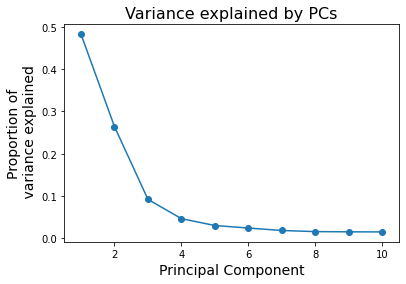

In [31]:
plt.plot(range(1,11),[i/sum(eign_list) for i in eign_list],marker="o")
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Proportion of\n variance explained", fontsize=14)
plt.xlim([0.5,10.5])
plt.title("Variance explained by PCs",fontsize=16)

Text(0, 0.5, 'PC2')

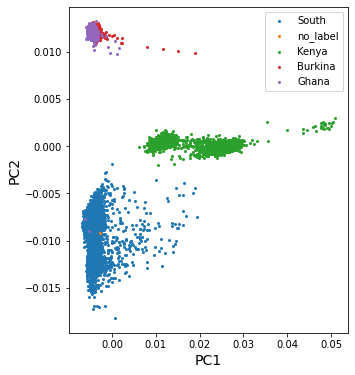

In [29]:
plt.figure(figsize=(5,6))

for pop in pca_df[11].unique():#.loc[0][0].strip(" ")#[0].split("\t")
    plt.scatter(pca_df[pca_df[11]==pop][2],
                pca_df[pca_df[11]==pop][1],
                label=pop,
                s=4)

plt.legend()
plt.xlabel("PC1",fontsize=14)
plt.ylabel("PC2",fontsize=14)

### Kinship compare

In [5]:
filtered_file="/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/kinship/filtered_SNPs_kinship.kin0"
filtered_kin = pd.read_csv(filtered_file,sep="\t", usecols=["IID1","IID2","KINSHIP"])

In [6]:
all_file="/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/kinship/all_SNPs_kinship.kin0"
all_kin = pd.read_csv(filtered_file,sep="\t", usecols=["IID1","IID2","KINSHIP"])
all_kin = all_kin.merge(filtered_kin,on=["IID1","IID2"],suffixes=["_all","_filtered"])

In [7]:
print(f"There are {len(all_kin):,} paired kinship, and {sum(all_kin.KINSHIP_all==all_kin.KINSHIP_filtered):,} are the same")

There are 58,055,700 paired kinship, and 58,055,700 are the same


In [8]:
print(f"{(all_kin.KINSHIP_all>0.177).sum():,} are third degree related samples (under the 0.177 threshold).")

695 are third degree related samples (under the 0.177 threshold).


## 3. Prepare phenotypes and covariates

In [5]:
phnoe_excel = pd.ExcelFile(pheno_folder+"/EGAF00004691445/V2.0_AWI-Gen_Code_Book-EGA_Variables.xlsx")
phnoe_excel.sheet_names

['Main',
 '1. Demographic Information',
 '2. Behaviour_Lifestyle',
 '3. Health History',
 '4. Family History',
 '5. Exposure',
 '6. Infection History',
 '7. Cardiovascular Disease Risk',
 '8. Measurements & Calculations']

### Check covariates

In [6]:
demo_df = phnoe_excel.parse('1. Demographic Information',skiprows=2)

In [38]:
display(demo_df.set_index("Variable Name").loc["age"]["Categorical Description"])
display(demo_df.set_index("Variable Name").loc["sex"]["Categorical Description"])
print("### Check number of samples missing covariates ###")
print(f"{len(pheno_df)-pheno_df.sex.isin([0,1]).sum()-1:,} samples don't have sex information.")
print(f"{len(pheno_df)-(~pheno_df.age.isnull()).sum()-1:,} samples don't have age information.")

'Difference between date of birth and date of collection'

'0 - Female\n1 - Male\nBlank - not answered'

### Check number of samples missing covariates ###
0 samples don't have sex information.
0 samples don't have age information.


## Check phenotypes and prepare files for GWAS

In [16]:
measure_df = phnoe_excel.parse('8. Measurements & Calculations',skiprows=2)
display(f'({measure_df.loc[21,"Variable Name"]}, {measure_df.loc[21,"Categorical Description"]}),\
 {pheno_df["ldl_qc"].isin([-999,-111,-222]).sum()} samples with invalid/out-of-bound values))')

display(f'({measure_df.loc[22,"Variable Name"]}, {measure_df.loc[22,"Categorical Description"]},\
 {pheno_df["friedewald_ldl_c_c_qc"].isin([-999]).sum()} samples with invalid values))')

display(f'({measure_df.loc[20,"Variable Name"]}, {measure_df.loc[22,"Categorical Description"]},\
 {pheno_df["hdl_qc"].isin([-999]).sum()} samples with invalid values))')

'(ldl_qc, -999 - Missing\n-111 - Out-of-range (lower bound)\n-222 - Out-of-range (up bound)), 1413 samples with invalid/out-of-bound values))'

'(friedewald_ldl_c_c_qc, -999 = invalid \n, 345 samples with invalid values))'

'(hdl_qc, -999 = invalid \n, 313 samples with invalid values))'

In [30]:
measure_df

,Variable Name,Data Type,Unit,Description,Categorical Description,Notes & Exceptions
0,standing_height_qc,Continuous,mm,Standing height\n,-999 - Missing,NaN
1,weight_qc,Continuous,kg,Weight\n,-999 - Missing,NaN
2,bmi_c_qc,Continuous,kg/m2,BMI (calculated),-999 - Missing,NaN
3,bmi_cat_c_qc,Continuous,weight in \nkg/height in m2,BMI (categorical) (calculated),0 - underweight is a BMI<18.5\n1 - normal weig...,NaN
4,waist_circumference_qc,Continuous,mm,Waist circumference\n,-999 - Missing,Exception: Missing data for Agincourt over 70 ...
5,hip_circumference_qc,Continuous,mm,Hip circumference\n,-999 - Missing,Exception: Missing data for Agincourt over 70 ...
6,waist_hip_r_c_qc,Continuous,NaN,Waist-to-hip ratio (calculated),-999 - Missing\n,Exception: Agincourt data missing for over 70 ...
7,bp_sys_average_qc,Continuous,mmHg,Average systolic blood pressure\n,-999 - Missing,NaN
8,bp_dia_average_qc,Continuous,mmHg,Average diastolic blood pressure\n,-999 - Missing,NaN
9,htn_jnc7_qc,Categorical,NaN,Hypertension status (calculated)\n\n,0 - no hypertension\n1 - hypertension present\...,"Note self report HT, or SBP >=140 or DBP >= 90..."


In [9]:
[i for i in pheno_df.columns.tolist() if "hdl" in i]

['hdl_qc', 'non_hdl_c_c_qc']

In [ ]:
display(f'({measure_df.loc[22,"Variable Name"]}, {measure_df.loc[22,"Categorical Description"]},\
 {pheno_df["friedewald_ldl_c_c_qc"].isin([-999]).sum()} samples with invalid values))')

In [64]:
health_df = phnoe_excel.parse('7. Cardiovascular Disease Risk',skiprows=2)
display(f'({health_df.loc[27,"Variable Name"]}, {health_df.loc[27,"Categorical Description"]})')
display(f'({pheno_df["cholesterol_treatment_qc"].isin([-999,-555]).sum()} samples with missing phenotypes)')

"(cholesterol_treatment_qc, 0 - No\n1 - Yes\n2 - Don't Know\n-999 - Missing\n-555 - Not Applicable)"

'(11956 samples with missing phenotypes)'

--pheno causes (additional) phenotype values to be read from the specified space- or tab-delimited file. The first columns of that file must be either FID/IID or just IID (in which case the FID is assumed to be 0). A primary header line is required when using --pheno-name, and optional without it (if it's present, it should begin with 'FID', '#FID', 'IID', or '#IID'). Additional header lines (beginning with '#', not immediately followed by 'FID'/'IID') are permitted before the primary header line. For example:

#IID  qt1    bmi    site
1110  2.3    22.22  site2
2202  34.12  18.23  site1

### Save the phenotypes and covariates samples

#### ldl

In [99]:
valid_pheno = set(pheno_df[~pheno_df["friedewald_ldl_c_c_qc"].isin([-999])].study_id)
pca_pheno_shared = list(set(pca_df[0]) & set(pheno_df["study_id"]) & valid_pheno)

In [100]:
# filtered samples for phenotypes
selected_pheno_df=pheno_df.set_index("study_id").loc[pca_pheno_shared][["age","sex","friedewald_ldl_c_c_qc"]].reset_index()
selected_pheno_df.rename(columns={"study_id":"#IID"},inplace=True)
selected_pheno_df["sex"]=selected_pheno_df.sex.astype(int)
selected_pheno_df["age"]=selected_pheno_df.age.astype(int)
selected_pheno_df.set_index("#IID",inplace=True)

# filtered samples for PCs
selected_pc = pca_df[range(0,6)].copy()
selected_pc.columns=["#IID"]+[ f"PC{i}" for i in pca_df.columns.tolist()[1:6]]
selected_pc=selected_pc.set_index("#IID").loc[pca_pheno_shared]

In [99]:
save_dir="/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/regression_files/friedewald_ldl_c"

In [103]:
final_pheno = selected_pheno_df[["friedewald_ldl_c_c_qc"]].copy()
final_pheno.to_csv(f"{save_dir}/friedewald_ldl_pheno.tsv",sep="\t")

<AxesSubplot:>

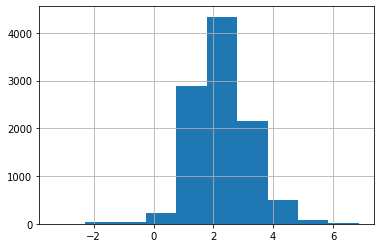

In [105]:
final_pheno.friedewald_ldl_c_c_qc.hist()

In [102]:
final_cov = selected_pheno_df[["age","sex"]].merge(selected_pc,left_index=True,right_index=True)
final_cov.to_csv(f"{save_dir}/ldlc_covs.tsv",sep="\t")

# hdl

In [19]:
valid_pheno = set(pheno_df[~pheno_df["hdl_qc"].isin([-999])].study_id)
pca_pheno_shared = list(set(pca_df[0]) & set(pheno_df["study_id"]) & valid_pheno)

In [24]:
# filtered samples for phenotypes
selected_pheno_df=pheno_df.set_index("study_id").loc[pca_pheno_shared][["age","sex","hdl_qc"]].reset_index()
selected_pheno_df.rename(columns={"study_id":"#IID"},inplace=True)
selected_pheno_df["sex"]=selected_pheno_df.sex.astype(int)
selected_pheno_df["age"]=selected_pheno_df.age.astype(int)
selected_pheno_df.set_index("#IID",inplace=True)

# filtered samples for PCs
selected_pc = pca_df[range(0,6)].copy()
selected_pc.columns=["#IID"]+[ f"PC{i}" for i in pca_df.columns.tolist()[1:6]]
selected_pc=selected_pc.set_index("#IID").loc[pca_pheno_shared]

In [22]:
save_dir="/expanse/protected/gymreklab-dbgap/mount/H3Africa/DS_I_Africa_project/from_ilifu/results/GWAS/regression_files/hdl_qc"
os.makedirs(save_dir)

In [28]:
final_pheno = selected_pheno_df[["hdl_qc"]].copy()
final_pheno.to_csv(f"{save_dir}/hdl_qc_pheno.tsv",sep="\t")

In [29]:
final_cov = selected_pheno_df[["age","sex"]].merge(selected_pc,left_index=True,right_index=True)
final_cov.to_csv(f"{save_dir}/hdl_covs.tsv",sep="\t")